# 选股表格回测
1. 等权重下单
2. 按照特定权重下单
3. 策略优化

In [1]:
from jaqs.data.dataapi import DataApi
from jaqs.data import DataView
from jaqs.research import SignalDigger
import numpy as np
from datetime import datetime
import pandas as pd
from datetime import timedelta
import warnings

warnings.filterwarnings("ignore")

dataview_folder = 'JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dataview loaded successfully.


In [2]:
def change_columns_index(signal):
    new_names = {}
    for c in signal.columns:
        if c.endswith('SZ'):
            new_names[c] = c.replace('SZ', 'XSHE')
        elif c.endswith('SH'):
            new_names[c] = c.replace('SH', 'XSHG')
    signal = signal.rename_axis(new_names, axis=1)
    signal.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , signal.index))
    signal.index = pd.Index(map(lambda x: x+timedelta(hours=15), signal.index))
    return signal

In [3]:
mask = dv.get_ts('mask_fundamental')
group = change_columns_index(dv.get_ts('group'))
ROE_Data = change_columns_index(dv.get_ts('roe').shift(1, axis=0)[mask==0])
prices = change_columns_index(dv.get_ts('close_adj'))

In [4]:
def get_largest(df, n=20):
    largest_list = []
    for time_index, value in df.iterrows():
        largest_list.append(dict.fromkeys(value.nlargest(n).index,1))
    largest_df = pd.DataFrame(largest_list, index = df.index)
    return largest_df

In [5]:
stock_df = get_largest(ROE_Data).dropna(how='all', axis=1)

In [12]:
stock_df.to_excel('roe_backtest.xlsx')

## 等权重下单

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


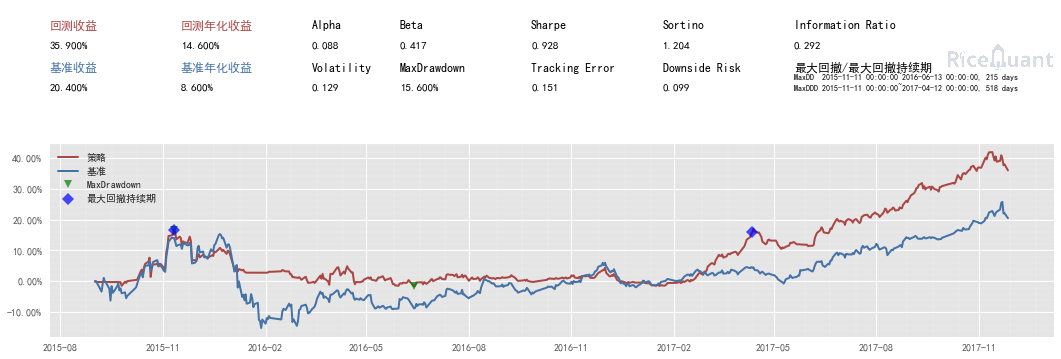

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2015-09-01  1462.24     998537.76                  1.000   1000000.00   
  2015-09-02  1462.24     999651.51                  1.000   1001113.75   
  2015-09-07  1462.24     965392.56                  1.001    966854.80   
  2015-09-08  1462.24     990203.94                  0.967    991666.18   
  2015-09-09  1462.24    1009595.07                  0.992   1011057.31   
  2015-09-10  1462.24     997195.32                  1.011    998657.56   
  2015-09-11  1462.24     994115.43                  0.999    995577.67   
  2015-09-14  1462.24     974495.61                  0.996    975957.85   
  2015-09-15  1462.24     936212.31                  0.976    937674.55   
  2015-09-16  1462.24     982847.25                  0.938    984309.49   
  2015-09-17  1462.24     961389.00                  0.984   

In [7]:
import numpy as np
import talib as ta
import pandas as pd
import rqalpha
from rqalpha.api import *

#读取文件位置
def init(context):
    context.codes = stock_df
    context.stocks = []
    context.SHORTPERIOD = 20
#     scheduler.run_weekly(find_pool, tradingday=1)
    scheduler.run_daily(find_pool)

def find_pool(context, bar_dict):
    try:
        codes = context.codes.loc[context.now]
    except KeyError:
        return
    stocks = codes.index[codes == 1]
    context.stocks = stocks

def handle_bar(context, bar_dict):
    buy(context, bar_dict)
    
    
def buy(context, bar_dict):
    pool = context.stocks
#     print (pool)
    if pool is not None:
        stocks_len = len(pool)
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        for codes in pool:
            try:
                price = history_bars(codes, context.SHORTPERIOD+10, '1d', 'close')
                short_avg = ta.SMA(price, context.SHORTPERIOD)
                cur_position = context.portfolio.positions[codes].quantity
                if short_avg[-1]<short_avg[-3] and cur_position > 0:
                    order_target_value(codes, 0)
                if short_avg[-1]  > short_avg[-3]:
                    order_target_percent(codes, 1.0/stocks_len)
            except Exception:
                pass


config = {
  "base": {
    "start_date": "2015-09-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000300.XSHG"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 按照特定权重下单

In [8]:
def get_largest_weight(df, n=20):
    largest_list = []
    for time_index, value in df.iterrows():
        largest_list.append(value.nlargest(n).to_dict())
    largest_df = pd.DataFrame(largest_list, index = df.index)
    return largest_df

In [9]:
largest_weight = get_largest_weight(ROE_Data)

In [10]:
weight_list = []
for time_index, weight in largest_weight.iterrows():
    weight[weight<0]=0
    weiht_result = (weight/weight.sum())
    weight_list.append(weiht_result.to_dict())
weight_df = pd.DataFrame(weight_list, index=largest_weight.index)

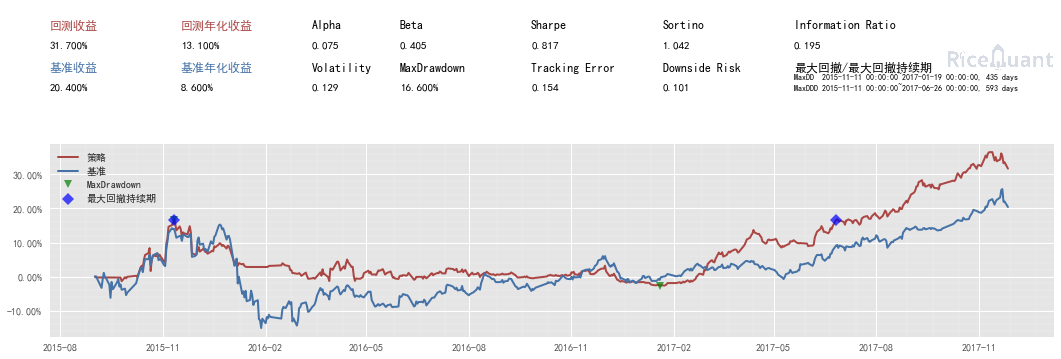

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2015-09-01  1462.24     998537.76                  1.000   1000000.00   
  2015-09-02  1462.24     999651.51                  1.000   1001113.75   
  2015-09-07  1462.24     965392.56                  1.001    966854.80   
  2015-09-08  1462.24     990203.94                  0.967    991666.18   
  2015-09-09  1462.24    1009595.07                  0.992   1011057.31   
  2015-09-10  1462.24     997195.32                  1.011    998657.56   
  2015-09-11  1462.24     994115.43                  0.999    995577.67   
  2015-09-14  1462.24     974495.61                  0.996    975957.85   
  2015-09-15  1462.24     936212.31                  0.976    937674.55   
  2015-09-16  1462.24     982847.25                  0.938    984309.49   
  2015-09-17  1462.24     961389.00                  0.984   

In [11]:
import numpy as np
import talib as ta
import pandas as pd
import rqalpha
from rqalpha.api import *

#读取文件位置
def init(context):
    context.codes = weight_df
    context.hs300 = '000300.XSHG'
    context.SHORTPERIOD = 20
    context.stocks = {}
    scheduler.run_daily(find_pool)
#     scheduler.run_weekly(find_pool,tradingday=3)

def find_pool(context, bar_dict):
    codes = context.codes.loc[context.now].dropna()
    if codes is not None:
        context.stocks = codes
    else:
        context.stocks = {}

def handle_bar(context, bar_dict):
    buy(context, bar_dict)
    
    
def buy(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        for codes, target in pool.items():
            try:
                price = history_bars(codes, context.SHORTPERIOD+10, '1d', 'close')
                short_avg = ta.SMA(price, context.SHORTPERIOD)
                cur_position = context.portfolio.positions[codes].quantity
                if short_avg[-1]<short_avg[-3] and cur_position > 0:
                    order_target_value(codes, 0)
                if short_avg[-1]  > short_avg[-3]:
                    order_target_percent(codes, target)
            except Exception:
                pass
                
config = {
  "base": {
    "start_date": "2015-09-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000300.XSHG"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 策略优化

安装链接： https://github.com/xingetouzi/rqalpha-mod-optimization

1. 导入模块
2. 设置参数
3. 设置回测的config
4. 启动回测并打印最好的参数

In [ ]:
import logging
from rqalpha_mod_optimization.optimizer import SimpleOptimizeApplication
from rqalpha_mod_optimization.parallel import set_parallel_method, ParallelMethod

params = {
    'SHORTPERIOD': range(5,40,5),
}

config = {
    "extra": {
        "log_level": "verbose",
    },
    "base": {
        "start_date": "2015-09-01",
        "end_date": "2017-12-30",
        "accounts": {'stock':1000000},
        "matching_type": "next_bar",
        "benchmark": "000300.XSHG",
        "frequency": "1d",
    }
}

if __name__ == "__main__":
    try:
        set_parallel_method(ParallelMethod.DASK)
        result = SimpleOptimizeApplication(config).open("ROE_MA_Strategy.py").optimize(params)
        print(result.sort_values(by=["sharpe"], ascending=False))
    except Exception as e:
        logging.exception(e)
        print("******POOL TERMINATE*******")